In [7]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

from scipy.interpolate import interp1d

#from labellines import labelLine, labelLines
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [8]:
Q_EC_100Tc=0.172 #in MeV
Z_100Tc=43

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

Be384_en = 0.384 #Mev 
Be862_en = 0.862 #Mev

S_n = 6.764 #энергия отрыва нейтрона
#total_IAS = 21
#total_GT = 63

Функция для расчета порога реакции

In [9]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [10]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [11]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [12]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [13]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/Janecki Z43.xls')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
p0       48 non-null float64
Value    48 non-null float64
dtypes: float64(2)
memory usage: 848.0 bytes


In [14]:
Fermi_func_new_data.head()

,p0,Value
0,0.1,38.6550
1,0.2,19.5400
2,0.3,13.2650
3,0.4,10.2150
4,0.5,8.4623


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [15]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['p0'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['Value'].values )

### BS05_OP flux

In [16]:
BS05OP_Be = 4.84e9
BS05OP_pp = 5.99e10
BS05OP_pep = 1.42e8
BS05OP_hep = 7.93e3
BS05OP_B = 5.69e6
BS05OP_N = 3.07e8
BS05OP_0 = 2.33e8
BS05OP_F = 5.84e6

In [17]:
BP98_Be = 4.80e9
BP98_pp = 5.94e10
BP98_pep = 1.39e8
BP98_hep = 2.10e3
BP98_B = 5.15e6 
BP98_N = 6.05e8
BP98_0 = 5.32e8
BP98_F = 6.33e6

In [18]:
BP98_OPAL92_Be = 4.94e9
BP98_OPAL92_pp = 5.92e10
BP98_OPAL92_pep = 1.39e8
BP98_OPAL92_hep = 2.08e3
BP98_OPAL92_B = 5.44e6 
BP98_OPAL92_N = 6.25e8
BP98_OPAL92_0 = 5.52e8
BP98_OPAL92_F = 6.59e6

In [19]:
#B16-GS98 - high metallicity
B16_GS98_Be = 4.93e9
B16_GS98_pp = 5.98e10
B16_GS98_pep = 1.44e8
B16_GS98_hep = 7.98e3
B16_GS98_B = 5.46e6 
B16_GS98_N = 2.78e8
B16_GS98_0 = 2.05e8
B16_GS98_F = 5.29e6

In [20]:
#B16-AGSS09met - low metallicity
B16_AGSS09met_Be = 4.50e9
B16_AGSS09met_pp = 6.03e10
B16_AGSS09met_pep = 1.46e8
B16_AGSS09met_hep = 8.25e3
B16_AGSS09met_B = 4.50e6 
B16_AGSS09met_N = 2.04e8
B16_AGSS09met_0 = 1.44e8
B16_AGSS09met_F = 3.26e6

In [21]:
#fluxes_df = pd.DataFrame()

In [22]:
step_all_fluxes = 0.001 #MeV
Energy_all_fluxes = np.arange(0,20,step_all_fluxes)

In [23]:
def return_flux(pp_ampl, hep_ampl, B_ampl, N_ampl, O_ampl, F_ampl, 
                energy_list = Energy_all_fluxes):
    pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
    b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
    hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
    n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
    o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
    f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')

    flux = {
        'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                       fp=pp['Probability'].values * pp_ampl ),
        'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                       fp=b8['Probability'].values * B_ampl ),
        'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                       fp=hep['Probability'].values * hep_ampl ),
        'n13':np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                       fp=n13['Probability'].values * N_ampl ),
        'o15':np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, 
                       fp=o15['Probability'].values * O_ampl ),
        'f17':np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, 
                       fp=f17['Probability'].values * F_ampl ),
    }
    return flux

In [24]:
BS05OP_flux = return_flux(pp_ampl=BS05OP_pp, 
                          hep_ampl=BS05OP_hep,
                          B_ampl=BS05OP_B,
                          N_ampl=BS05OP_N,
                          O_ampl=BS05OP_0,
                          F_ampl=BS05OP_F)

BP98_flux = return_flux(pp_ampl=BP98_pp, 
                          hep_ampl=BP98_hep,
                          B_ampl=BP98_B,
                          N_ampl=BP98_N,
                          O_ampl=BP98_0,
                          F_ampl=BP98_F)

BP98_OPAL92_flux = return_flux(pp_ampl=BP98_OPAL92_pp, 
                          hep_ampl=BP98_OPAL92_hep,
                          B_ampl=BP98_OPAL92_B,
                          N_ampl=BP98_OPAL92_N,
                          O_ampl=BP98_OPAL92_0,
                          F_ampl=BP98_OPAL92_F)

B16_GS98_flux = return_flux(pp_ampl=B16_GS98_pp, 
                          hep_ampl=B16_GS98_hep,
                          B_ampl=B16_GS98_B,
                          N_ampl=B16_GS98_N,
                          O_ampl=B16_GS98_0,
                          F_ampl=B16_GS98_F)

B16_AGSS09met_flux = return_flux(pp_ampl=B16_AGSS09met_pp, 
                          hep_ampl=B16_AGSS09met_hep,
                          B_ampl=B16_AGSS09met_B,
                          N_ampl=B16_AGSS09met_N,
                          O_ampl=B16_AGSS09met_0,
                          F_ampl=B16_AGSS09met_F)

In [25]:
#!pip install matplotlib-label-lines

### B(GT) data

E_x до 5 МэВ!!!

In [29]:
BGT=pd.read_excel('../B(GT) peaks processing/recognition/Mo100/bgt.xls') #таблица со значениями B(GT)
BGT.head()

,Ex,bgt
0,0,0.3487
1,355,0.0394
2,838,0.0242
3,1339,0.0413
4,1416,0.0312


#### table B(GT) summ

In [30]:
table_BGT = np.sum(BGT['bgt'].values)
print(table_BGT)

0.5995


### Cross-section and total rate

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [31]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [32]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [33]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, fluxes_dict, energies_array, step, func_pep_ampl = BS05OP_pep, 
              func_Be_ampl = BS05OP_Be, name = 'test1'):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    output_dict = {'name':name}
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step) * math.pow(10,36)
        #print(elem, ' ', rate)
        output_dict[elem] = rate
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep*math.pow(10,36)
    #print('pep', ' ', rate_pep)
    output_dict['pep'] = rate_pep
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384*math.pow(10,36) #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862*math.pow(10,36)
    rate_Be = rate_Be384 + rate_Be862
    
    #print('Be', ' ', rate_Be)
    output_dict['Be'] = rate_Be
    rate_total+=rate_Be
    
    #print('rate_total',' ', rate_total)
    output_dict['Total'] = rate_total
    return output_dict

In [32]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

In [34]:
sigma_less5=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_100Tc, Q_EC_100Tc) 
                  for (BGT_k, E_k) in zip(BGT['bgt'].values, BGT['Ex'].values)]) 
             for E_nu in Energy_all_fluxes]

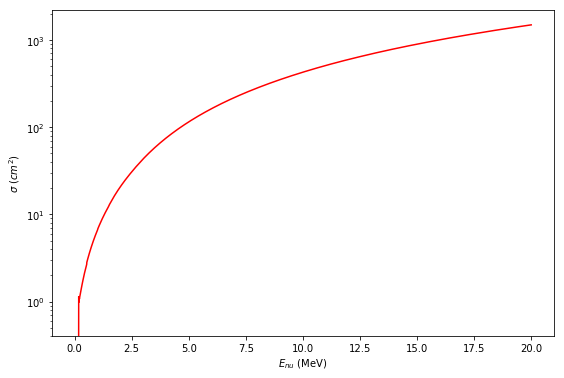

In [35]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_less5, c='r')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')

In [36]:
rate_calc(sigma_less5, BS05OP_flux, Energy_all_fluxes, step_all_fluxes)

{'Be': 241.08500098435243,
 'Total': 1026.6675174117338,
 'b8': 13.089402365760952,
 'f17': 0.41586624004011546,
 'hep': 0.034935952868154985,
 'n13': 13.05433404809197,
 'name': 'test1',
 'o15': 16.512166422834227,
 'pep': 16.68814124083035,
 'pp': 725.7876701569556}

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [37]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [38]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [39]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

сечение без Sn

In [39]:
p_list = np.arange(0,20, 0.01) #p = z - Q

sigma_no_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['Ex, MeV'].values, y, 200) for p in p_list]

sigma_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

сечение с Sn

In [40]:
sigma_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['Ex, MeV'].values, y_border, 200) for p in p_list]

sigma_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

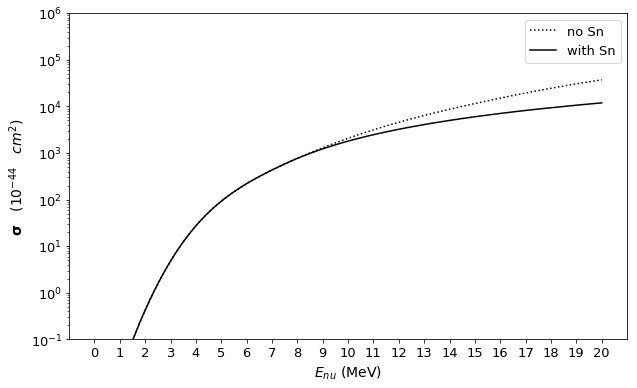

In [41]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_no_border_full, ls=':', c='black', 
         label='no Sn')
plt.plot(Energy_all_fluxes, sigma_border_full, ls='-', c='k', 
         label='with Sn')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(6))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

SNU с Sn

In [42]:
rate_calc(sigma_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.30822935728156703,
 'Total': 42.11398475672297,
 'b8': 41.43178422320444,
 'f17': 0.0017612308773412527,
 'hep': 0.1771487218685662,
 'n13': 0.0165790529772805,
 'name': 'test1',
 'o15': 0.06919678335842358,
 'pep': 0.10928538715535349,
 'pp': 0.0}

SNU без Sn

In [43]:
rate_calc(sigma_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.30822935728156703,
 'Total': 49.76482439905446,
 'b8': 48.972598109326036,
 'f17': 0.0017612308773412527,
 'hep': 0.28717447807845925,
 'n13': 0.0165790529772805,
 'name': 'test1',
 'o15': 0.06919678335842358,
 'pep': 0.10928538715535349,
 'pp': 0.0}

## IAS influence

(0, 20)

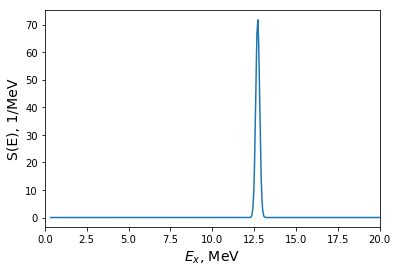

In [44]:
best_fit_IAS = pd.read_excel('127Xe_gaussIAS.xls')
y_IAS = best_fit_IAS['y'].values / trapz(best_fit_IAS['y'].values, best_fit_IAS['Ex, MeV'].values) \
* total_IAS

plt.plot(best_fit_IAS['Ex, MeV'].values, y_IAS)
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)

(11, 13)

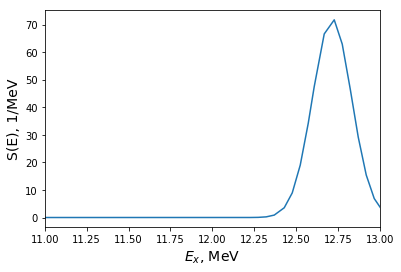

In [47]:
plt.plot(best_fit_IAS['Ex, MeV'].values, y_IAS)
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(11,13)

In [45]:
sigma_IAS_temp = [cross_sec(0,p, sigma_k_GTR, best_fit_IAS['Ex, MeV'].values, y_IAS, 200) for p in p_list]

sigma_IAS_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_IAS_temp)

In [46]:
rate_calc(sigma_IAS_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.0,
 'Total': 0.08032447422627868,
 'b8': 0.057455796830933714,
 'f17': 0.0,
 'hep': 0.022868677395344972,
 'n13': 0.0,
 'name': 'test1',
 'o15': 0.0,
 'pep': 0.0,
 'pp': 0.0}

### данные из графика BGT

In [39]:
bgt_full = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_full.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
bgt_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_0_5l.csv', 
                      sep=';', decimal=',', names=['x', 'y'])

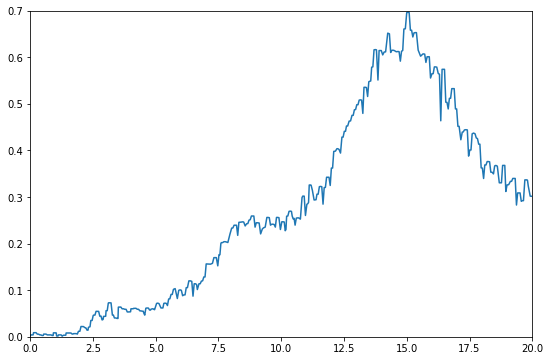

In [40]:
bgt = bgt_0_5.append(bgt_full[bgt_full['x']>5])

plt.figure(figsize=(9,6))
plt.plot(bgt['x'].values, bgt['y'].values)
plt.xlim(0,20)
plt.ylim(0,0.7)
plt.show()

In [41]:
trapz(bgt['y'].values, bgt['x'].values)

5.463277472256921

(0, 7)

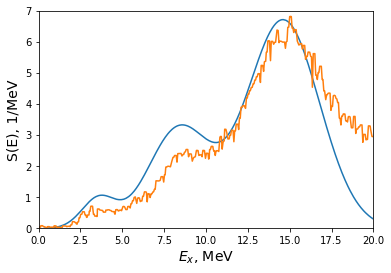

In [42]:
y_bgt = bgt['y'].values / trapz(bgt['y'].values, bgt['x'].values) \
* total_GT
y_bgt_border = border_func(bgt['x'].values, y_bgt, S_n)


plt.plot(best_fit['Ex, MeV'].values, y)
plt.plot(bgt['x'].values, y_bgt, )
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)
#plt.savefig('S_E_func_76Ge.png', format='png', dpi=400)


In [43]:
sigma_bgt_no_border_temp = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt, 200) for p in p_list]

sigma_bgt_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [44]:
sigma_bgt_border_temp = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt_border, 200) for p in p_list]

sigma_bgt_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

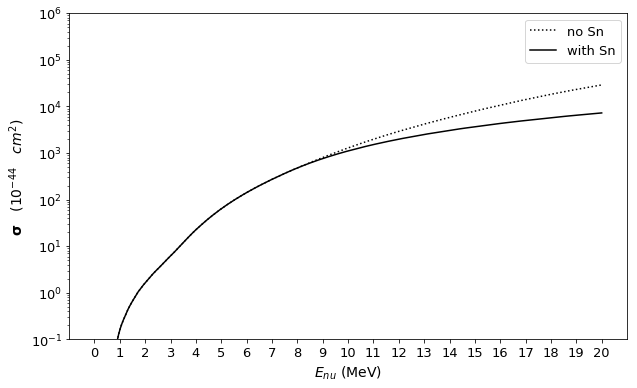

In [45]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_bgt_no_border_full, ls=':', c='black', 
         label='no Sn')
plt.plot(Energy_all_fluxes, sigma_bgt_border_full, ls='-', c='k', 
         label='with Sn')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(6))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

### BS05OP

In [46]:
rate_calc(sigma_bgt_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 2.9212454461204795,
 'Total': 30.293791523928103,
 'b8': 25.70602571411771,
 'f17': 0.013971570199011194,
 'hep': 0.10863860295563527,
 'n13': 0.1646452589248257,
 'name': 'test1',
 'o15': 0.5510984701356166,
 'pep': 0.8281664614748232,
 'pp': 0.0}

In [47]:
rate_calc(sigma_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 2.9212454461204795,
 'Total': 35.58909655543136,
 'b8': 30.917674604333477,
 'f17': 0.013971570199011194,
 'hep': 0.19229474424312676,
 'n13': 0.1646452589248257,
 'name': 'test1',
 'o15': 0.5510984701356166,
 'pep': 0.8281664614748232,
 'pp': 0.0}

### BP98

In [48]:
rate_calc(sigma_bgt_border_full, BP98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_pep, func_Be_ampl=BP98_Be,)

{'Be': 2.897102921772376,
 'Total': 28.60089002298328,
 'b8': 23.26643803650373,
 'f17': 0.015143842356120011,
 'hep': 0.028769365221542754,
 'n13': 0.32446378387465646,
 'name': 'test1',
 'o15': 1.2583020863182317,
 'pep': 0.8106699869366227,
 'pp': 0.0}

In [49]:
rate_calc(sigma_bgt_no_border_full, BP98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_pep, func_Be_ampl=BP98_Be,)

{'Be': 2.897102921772376,
 'Total': 33.34008961174459,
 'b8': 27.983484044344014,
 'f17': 0.015143842356120011,
 'hep': 0.050922946142568246,
 'n13': 0.32446378387465646,
 'name': 'test1',
 'o15': 1.2583020863182317,
 'pep': 0.8106699869366227,
 'pp': 0.0}

### BP98 OPAL92

In [50]:
rate_calc(sigma_bgt_border_full, BP98_OPAL92_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_OPAL92_pep, func_Be_ampl=BP98_OPAL92_Be,)

{'Be': 2.981601756990737,
 'Total': 30.053916489397146,
 'b8': 24.576586974481607,
 'f17': 0.015765864317034892,
 'hep': 0.028495371267051872,
 'n13': 0.3351898593746451,
 'name': 'test1',
 'o15': 1.3056066760294436,
 'pep': 0.8106699869366227,
 'pp': 0.0}

In [51]:
rate_calc(sigma_bgt_no_border_full, BP98_OPAL92_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_OPAL92_pep, func_Be_ampl=BP98_OPAL92_Be,)

{'Be': 2.981601756990737,
 'Total': 35.058525158134394,
 'b8': 29.5592530487828,
 'f17': 0.015765864317034892,
 'hep': 0.05043796570311522,
 'n13': 0.3351898593746451,
 'name': 'test1',
 'o15': 1.3056066760294436,
 'pep': 0.8106699869366227,
 'pp': 0.0}

### B16-GS98 (hight metallicity)

In [52]:
rate_calc(sigma_bgt_border_full, B16_GS98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=B16_GS98_pep, func_Be_ampl=B16_GS98_Be,)

{'Be': 2.975566125903711,
 'Total': 29.238282813733914,
 'b8': 24.666942073652493,
 'f17': 0.012655754512460482,
 'hep': 0.10932358784186247,
 'n13': 0.14909244944984215,
 'name': 'test1',
 'o15': 0.4848720445399201,
 'pep': 0.8398307778336236,
 'pp': 0.0}

###  B16-AGSS09met (low metallicity)

In [53]:
rate_calc(sigma_bgt_border_full, B16_AGSS09met_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=B16_AGSS09met_pep, func_Be_ampl=B16_AGSS09met_Be,)

{'Be': 2.7160339891616028,
 'Total': 24.468247117484992,
 'b8': 20.32989731344986,
 'f17': 0.0077991984330096735,
 'hep': 0.11302250622748942,
 'n13': 0.10940597009988418,
 'name': 'test1',
 'o15': 0.3405930459207244,
 'pep': 0.851495094192424,
 'pp': 0.0}

In [54]:
no11 = rate_calc(sigma_bgt_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='BS05OP with neutron separation')

no22 = rate_calc(sigma_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='BS05OP without neutron separation')

no33 = rate_calc(sigma_bgt_border_full, B16_GS98_flux, Energy_all_fluxes, 
                step_all_fluxes, name='B16-GS98 (hight metallicity) with neutron separation')

no44 = rate_calc(sigma_bgt_border_full, B16_AGSS09met_flux, Energy_all_fluxes, 
                step_all_fluxes, name='B16-AGSS09met (low metallicity) with neutron separation')



In [55]:
output_table0 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no11, no22, no33, no44] : 
    output_table0 = output_table0.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table0[elem] = output_table0[elem].round(3)
output_table0

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,BS05OP with neutron separation,2.921,0.014,25.706,0.165,0.828,0.551,0.109,0.0,30.294
1,BS05OP without neutron separation,2.921,0.014,30.918,0.165,0.828,0.551,0.192,0.0,35.589
2,B16-GS98 (hight metallicity) with neutron sepa...,2.921,0.013,24.667,0.149,0.828,0.485,0.109,0.0,29.172
3,B16-AGSS09met (low metallicity) with neutron s...,2.921,0.008,20.330,0.109,0.828,0.341,0.113,0.0,24.650


In [56]:
#output_table0.to_excel('models_comparison.xls')